## Deep Learning Model for Image Classification




# Importing the required librairies

In [25]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Importing data

In [26]:
data_dir = '../input/satellite-image-classification/data'
print("Classes: ", os.listdir(data_dir))

Classes:  ['cloudy', 'desert', 'green_area', 'water']


# visualize the image number of each class

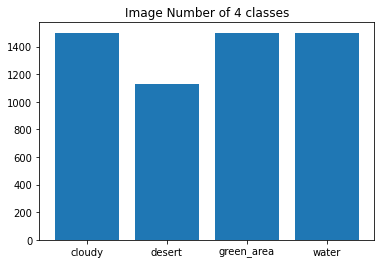

In [27]:
# visulize the number of each class
cloudy_dir = data_dir + '/cloudy'
desert_dir = data_dir + '/desert'
green_area_dir = data_dir + '/green_area'
water_dir = data_dir + '/water'

cloudy = len(os.listdir(cloudy_dir))
desert = len(os.listdir(desert_dir))
green_area = len(os.listdir(green_area_dir))
water = len(os.listdir(water_dir))

cc = ['cloudy', 'desert', 'green_area', 'water']
img_num = [cloudy,desert,green_area,water ]
plt.title('Image Number of 4 classes')
plt.bar(cc, img_num)
plt.show()


# Seperate the data into 3 sets, training, validation and test

In [28]:
# Define the transform
transform = transforms.Compose([transforms.RandomCrop(64, padding=4, padding_mode='reflect'),
                                transforms.Resize(64), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Import the dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Seperate the data set into train_set, validation_set and test_set
# 6 : 2 : 2
# total: 5631
# train: 3379
# validation: 1129
# test: 1129
print("Total number of images: ", len(dataset))
train_data, val_data,test_data = torch.utils.data.random_split(dataset, [3379, 1126, 1126])

print("Number of train data:", len(train_data))
print("Number of validation data:", len(val_data))
print("Number of test data:", len(test_data))

Total number of images:  5631
Number of train data: 3379
Number of validation data: 1126
Number of test data: 1126


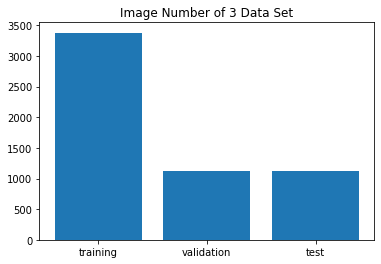

In [29]:
# visulize the number of 3 data set
cc = ['training', 'validation', 'test']
set_num = [len(train_data),len(val_data),len(test_data)]
plt.title('Image Number of 3 Data Set')
plt.bar(cc, set_num)
plt.show()

In [30]:
# define the batch size
batch_size = 16

# Loading the data into data loaders

In [31]:
# Loading the data into data loaders
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_data, batch_size, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, num_workers=2, pin_memory=True)

In [32]:
# Denormalize function
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

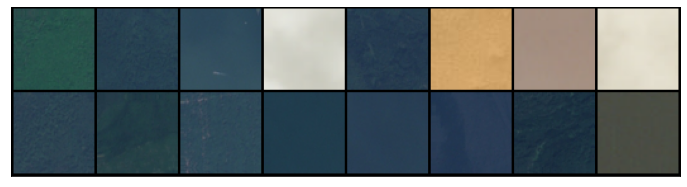

In [33]:
# show one batch
show_batch(train_dl)

# Using a GPU

In [34]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Model

In [37]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    # training
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    #validation
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc} # output the loss
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        # output data for each epoch
        print("Epoch {}, last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [38]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.AdaptiveAvgPool2d(2))
    return nn.Sequential(*layers)

class RegNet17(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 16)
        self.conv2 = conv_block(16, 32, pool=True)
        self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))
        
        self.conv3 = conv_block(32, 64)
        self.conv4 = conv_block(64, 128, pool=True)
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv5 = conv_block(128, 256, pool=True)
        self.conv6 = conv_block(256, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.conv7 = conv_block(512, 1024, pool=True)
        self.conv8 = conv_block(1024, 2048, pool=True)
        self.res4 = nn.Sequential(conv_block(2048, 2048),conv_block(2048, 2048))
        
       
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out)
        out = self.classifier(out)
        return out

In [39]:
model = to_device(RegNet17(3, 4), device)
model

RegNet17(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveAvgPool2d(output_size=2)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): Sequential(
    (0): Con

# Training the model

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Evaluating the model

In [41]:
history = [evaluate(model, valid_dl)]

# Set Parameters

In [42]:
epochs = 60 # number of epochs
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam # Optimizer

# Visualizing the loss for each epoch

In [43]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch 1, last_lr: 0.00047, train_loss: 0.6251, val_loss: 0.3592, val_acc: 0.8724
Epoch 2, last_lr: 0.00069, train_loss: 0.5164, val_loss: 0.3875, val_acc: 0.8451
Epoch 3, last_lr: 0.00104, train_loss: 0.6336, val_loss: 0.4531, val_acc: 0.8204
Epoch 4, last_lr: 0.00152, train_loss: 0.5784, val_loss: 0.4538, val_acc: 0.8181
Epoch 5, last_lr: 0.00211, train_loss: 0.6117, val_loss: 0.5169, val_acc: 0.7755
Epoch 6, last_lr: 0.00280, train_loss: 0.5925, val_loss: 0.4788, val_acc: 0.8075
Epoch 7, last_lr: 0.00356, train_loss: 0.6523, val_loss: 0.6443, val_acc: 0.7377
Epoch 8, last_lr: 0.00436, train_loss: 0.7804, val_loss: 0.5873, val_acc: 0.7245
Epoch 9, last_lr: 0.00520, train_loss: 0.6829, val_loss: 0.8384, val_acc: 0.5930
Epoch 10, last_lr: 0.00603, train_loss: 0.6351, val_loss: 0.6889, val_acc: 0.7573
Epoch 11, last_lr: 0.00684, train_loss: 0.5876, val_loss: 0.6278, val_acc: 0.7887
Epoch 12, last_lr: 0.00760, train_loss: 0.5992, val_loss: 0.5634, val_acc: 0.7207
Epoch 13, last_lr: 0.0082

## Testing



In [44]:
# predict the label with a label
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

# Test one image

Predicted: cloudy


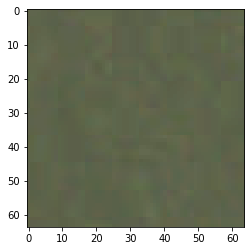

In [45]:
# Show one image in the test set and its prediction result
def check_one():
    test_idx = 10; # the test image index can be changed

    img = test_data[test_idx][0];
    label = test_data[test_idx][1];

    plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
    print('Predicted:', predict_image(img, model))

check_one();

# Test all image in test set

Test image 1 , Result: Correct  Predicted: cloudy , Real Class: cloudy
Test image 2 , Result: Correct  Predicted: green_area , Real Class: green_area
Test image 3 , Result: Wrong Predicted: water , Real Class: green_area
Test image 4 , Result: Correct  Predicted: desert , Real Class: desert
Test image 5 , Result: Correct  Predicted: desert , Real Class: desert
Test image 6 , Result: Wrong Predicted: water , Real Class: green_area
Test image 7 , Result: Correct  Predicted: water , Real Class: water
Test image 8 , Result: Wrong Predicted: green_area , Real Class: water
Test image 9 , Result: Correct  Predicted: cloudy , Real Class: cloudy
Test image 10 , Result: Correct  Predicted: water , Real Class: water
Test image 11 , Result: Correct  Predicted: cloudy , Real Class: cloudy
Test image 12 , Result: Correct  Predicted: water , Real Class: water
Test image 13 , Result: Correct  Predicted: desert , Real Class: desert
Test image 14 , Result: Correct  Predicted: water , Real Class: water
T

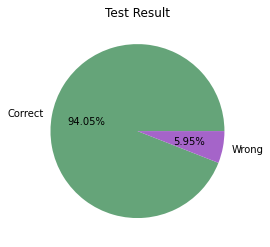

In [46]:
# Test every image in test set, and calculate the correct rate
def final_test():
    acc_count = 0;
    err_count = 0;

    for i in range(0, len(test_data)):

        img = test_data[i][0];
        label = test_data[i][1];

        predict_class = predict_image(img, model);
        real_class = dataset.classes[label]
        print("Test image", i+1, end = " , ")
        if predict_class == real_class:
            print("Result: Correct ", end = " ")
            acc_count += 1
        else:
            print("Result: Wrong", end = " ")
            err_count += 1
        print( "Predicted:", predict_class, ", Real Class:", real_class)

    total = acc_count + err_count
    print("=============================FINAL RESULT==============================")

    print ("Total image in test set:", total)
    print("Correct:", acc_count)
    print("Wrong:", err_count)
    print("Correct Rate:", 100*acc_count/total , "%")
    print("=======================================================================")
    
    # draw diagram
    y = np.array([acc_count, err_count])

    plt.pie(y,
        labels=['Correct','Wrong'], 
        colors=["#65a479", "#a564c9"], 
        autopct='%.2f%%',
#         explode=(0.2, 0)
       )
    plt.title("Test Result") 
    plt.show()
    
final_test()



In [47]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

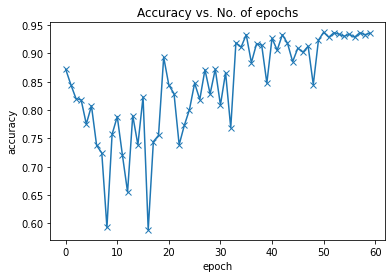

In [48]:
plot_accuracies(history)